In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

### Read Benchmark Data

In [69]:
benchmark_results_path = "../results/"
data = []
for root, dirs, files in os.walk(benchmark_results_path):
    for file in files:
        if file.endswith(".csv"):
            df_ = pd.read_csv(os.path.join(root, file))
            data.append(df_)

df = pd.concat(data)
human_and_random_scores = pd.read_csv("human_and_random_scores.csv")

In [70]:
df.head()

,model_name,env_id,prompt_chain,temperature,context_length,episode_reward,episode_length
0,Qwen/Qwen2.5-0.5B-Instruct,SpaceInvaders,simple,0.01,0,285.0,721
1,Qwen/Qwen2.5-0.5B-Instruct,SpaceInvaders,simple,0.01,0,285.0,718
2,Qwen/Qwen2.5-0.5B-Instruct,SpaceInvaders,simple,0.01,0,285.0,724
0,Qwen/Qwen2.5-0.5B-Instruct,SpaceInvaders,simple,0.01,2,240.0,771
1,Qwen/Qwen2.5-0.5B-Instruct,SpaceInvaders,simple,0.01,2,180.0,599


In [71]:
human_and_random_scores.head()

,model_name,env_id,prompt_chain,temperature,context_length,episode_reward,episode_length
0,random,Alien,NaN,NaN,NaN,227.8,0
1,human,Alien,NaN,NaN,NaN,7127.7,0
2,random,Amidar,NaN,NaN,NaN,5.8,0
3,human,Amidar,NaN,NaN,NaN,1719.5,0
4,random,Assault,NaN,NaN,NaN,222.4,0


### Aggregate Results for each Benchmark run

In [72]:
df['mean_reward'] = df.groupby(['model_name', 'env_id', 'prompt_chain', 'temperature', 'context_length'])['episode_reward'].transform('mean')
df['std_reward'] = df.groupby(['model_name', 'env_id', 'prompt_chain', 'temperature', 'context_length'])['episode_reward'].transform('std')
df['mean_length'] = df.groupby(['model_name', 'env_id', 'prompt_chain', 'temperature', 'context_length'])['episode_length'].transform('mean')
df['std_length'] = df.groupby(['model_name', 'env_id', 'prompt_chain', 'temperature', 'context_length'])['episode_length'].transform('std')

Separate data from random agent (baseline) and LLM agents

In [73]:
df = df[df["model_name"] != "random"]

### Plot

/tmp/ipykernel_2595632/1904513981.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


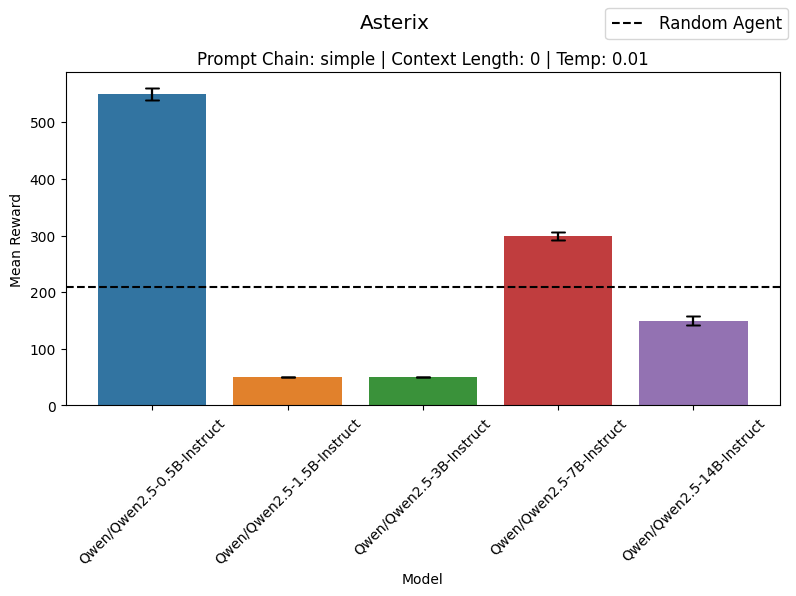

/tmp/ipykernel_2595632/1904513981.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


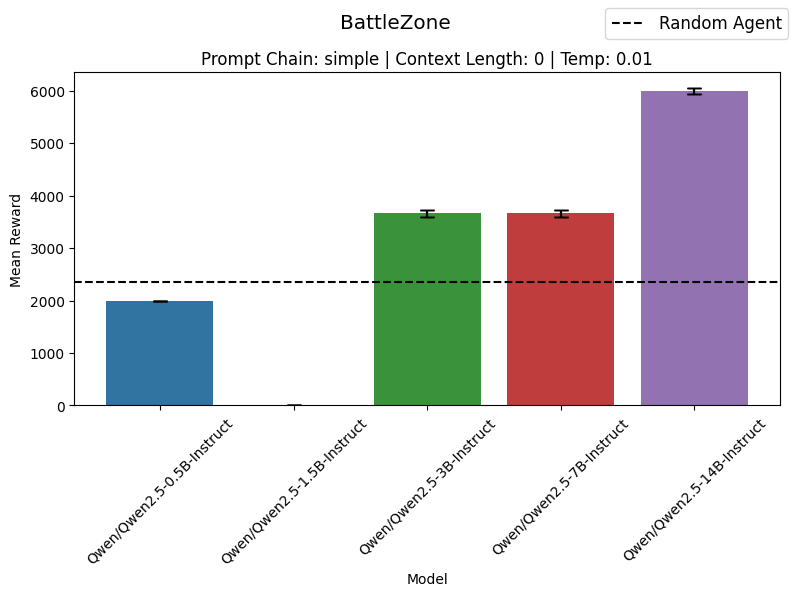

/tmp/ipykernel_2595632/1904513981.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


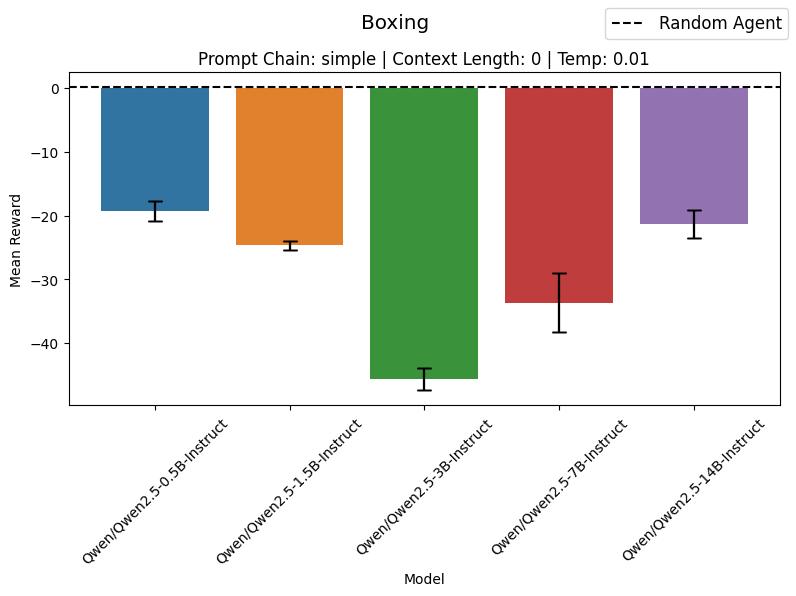

/tmp/ipykernel_2595632/1904513981.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


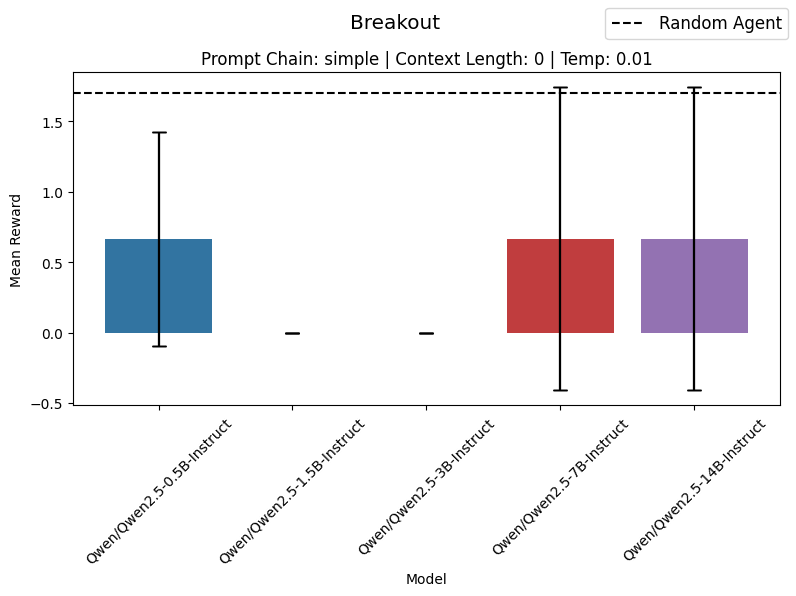

/tmp/ipykernel_2595632/1904513981.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


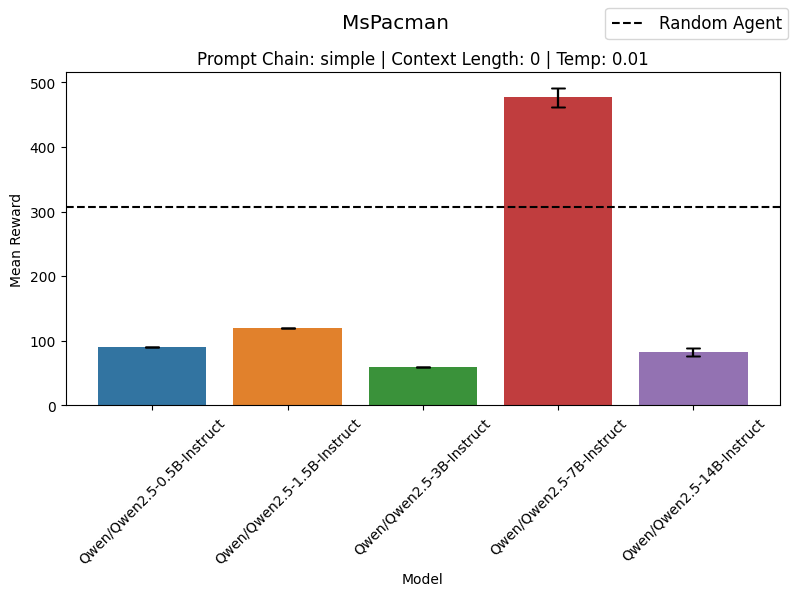

/tmp/ipykernel_2595632/1904513981.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


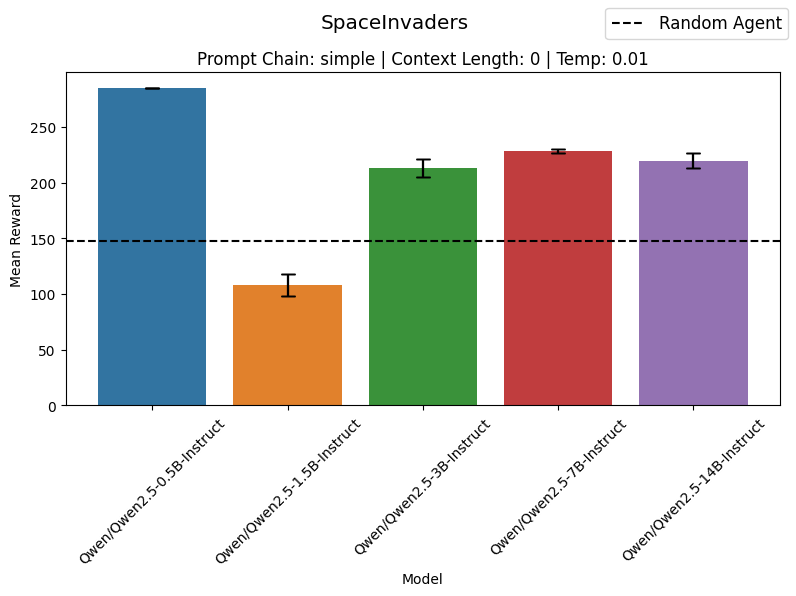

/tmp/ipykernel_2595632/1904513981.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


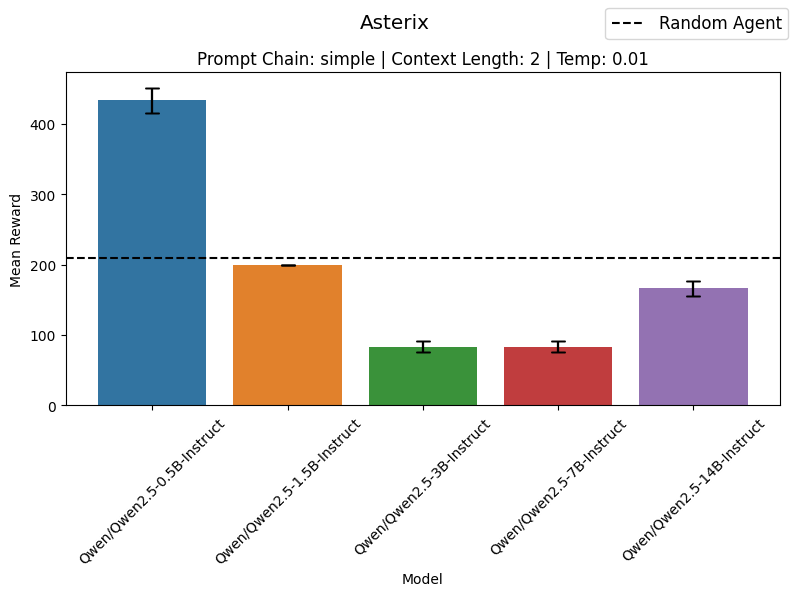

/tmp/ipykernel_2595632/1904513981.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


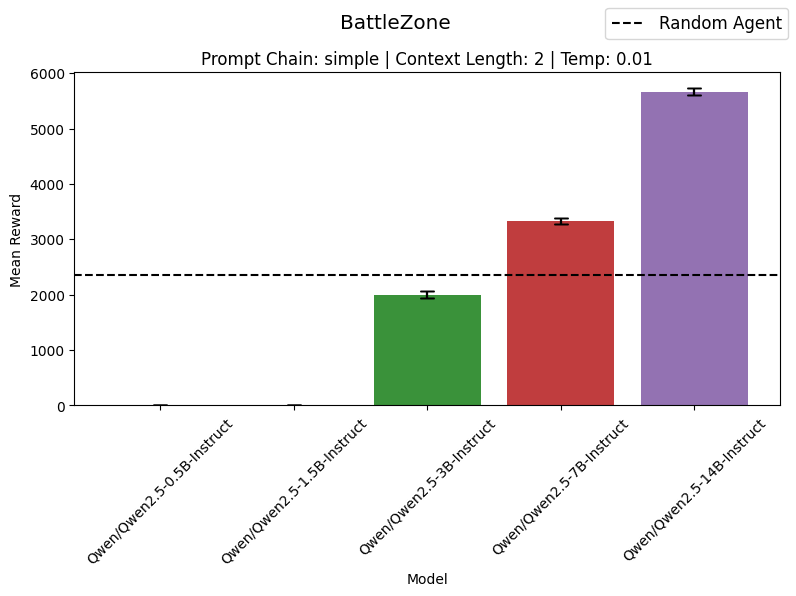

/tmp/ipykernel_2595632/1904513981.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


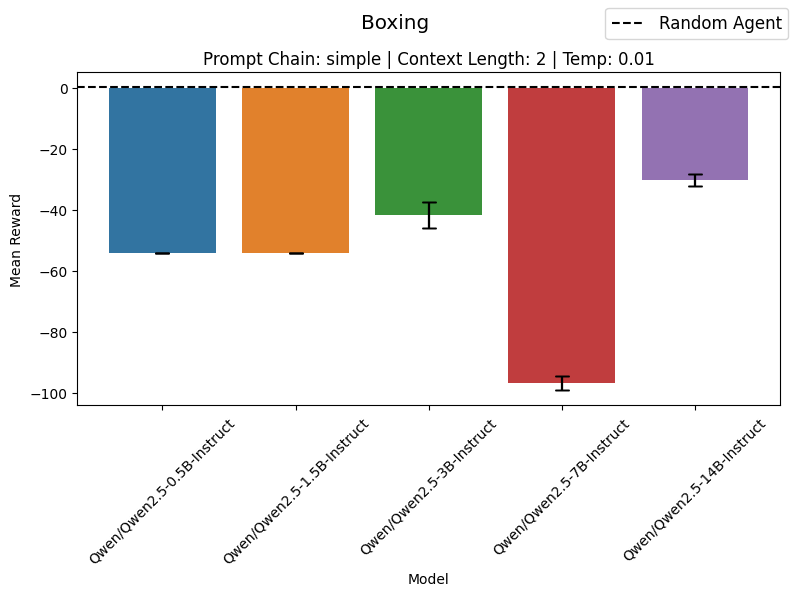

/tmp/ipykernel_2595632/1904513981.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


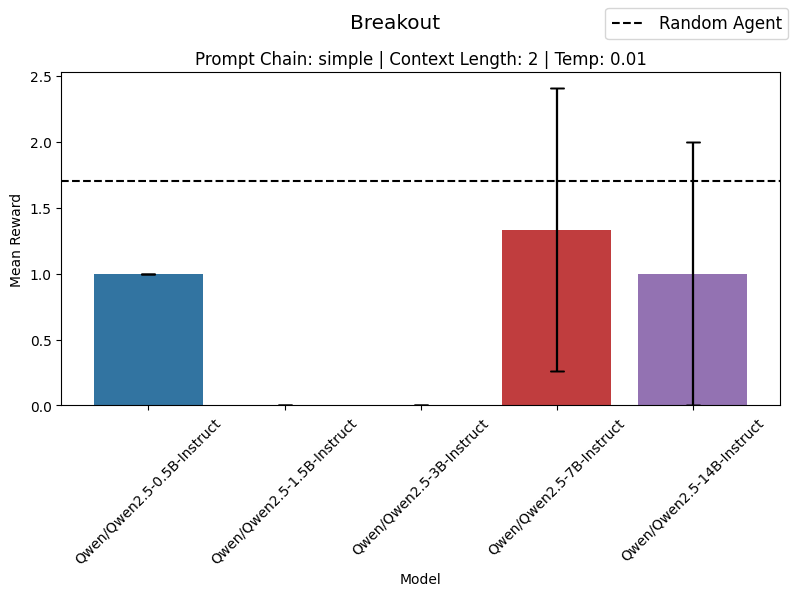

/tmp/ipykernel_2595632/1904513981.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


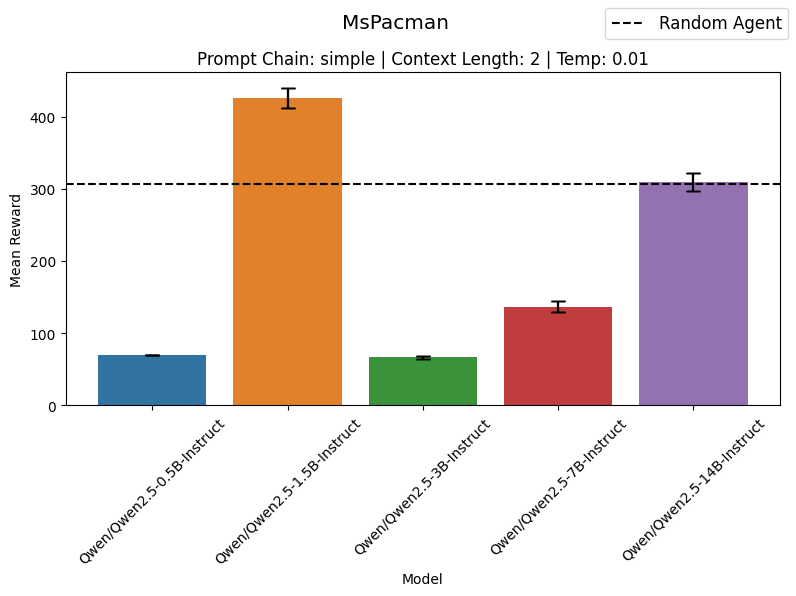

/tmp/ipykernel_2595632/1904513981.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


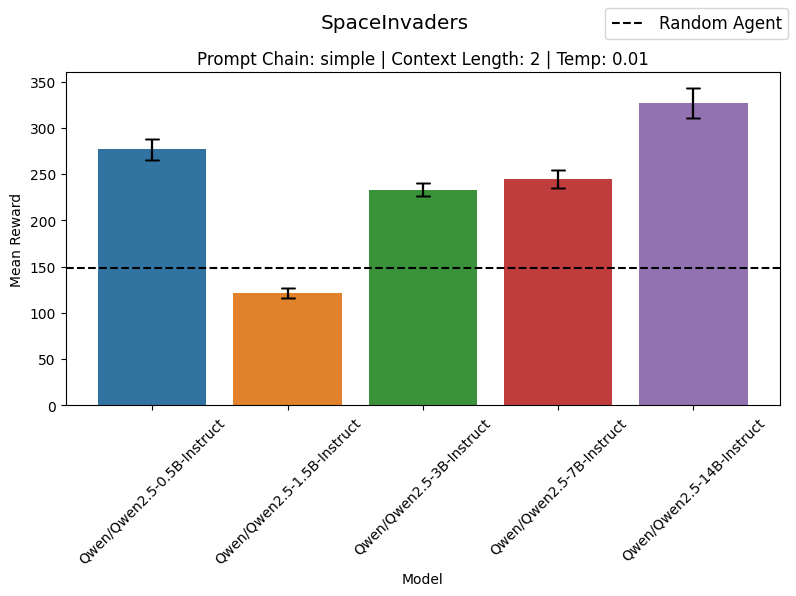

/tmp/ipykernel_2595632/1904513981.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


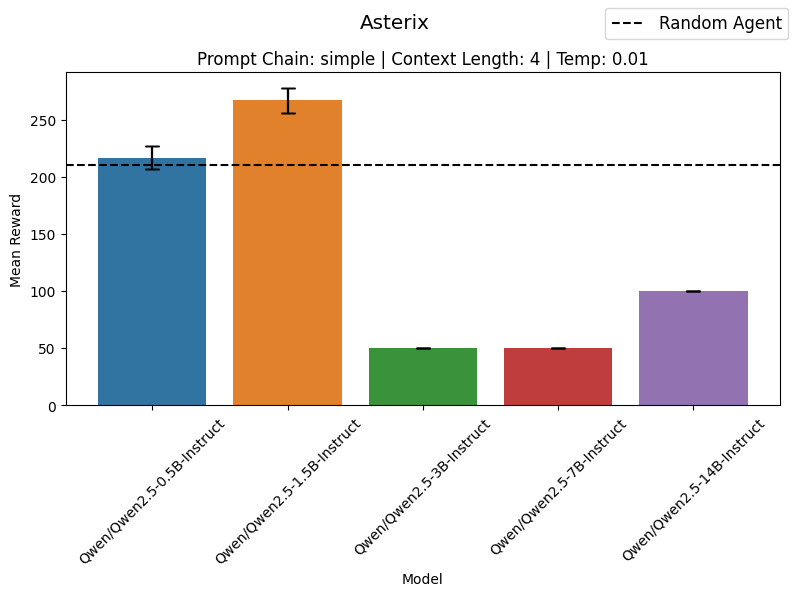

/tmp/ipykernel_2595632/1904513981.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


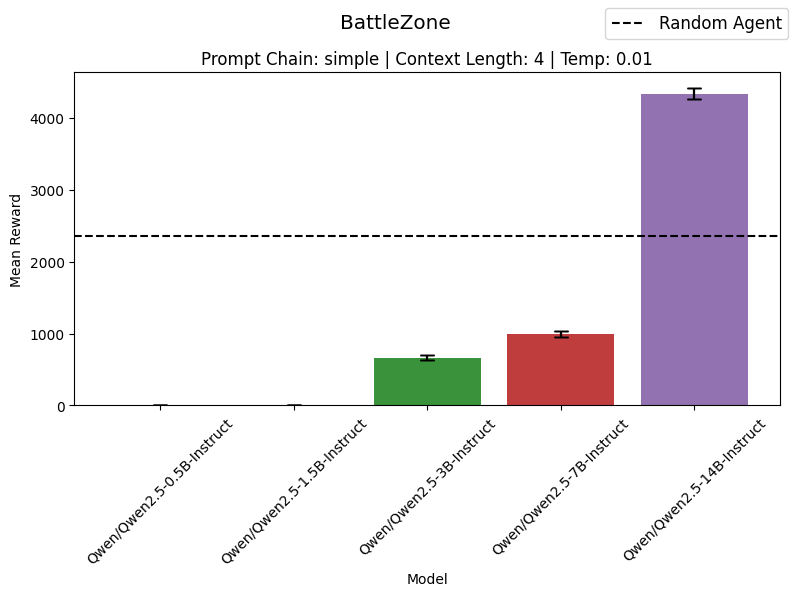

/tmp/ipykernel_2595632/1904513981.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


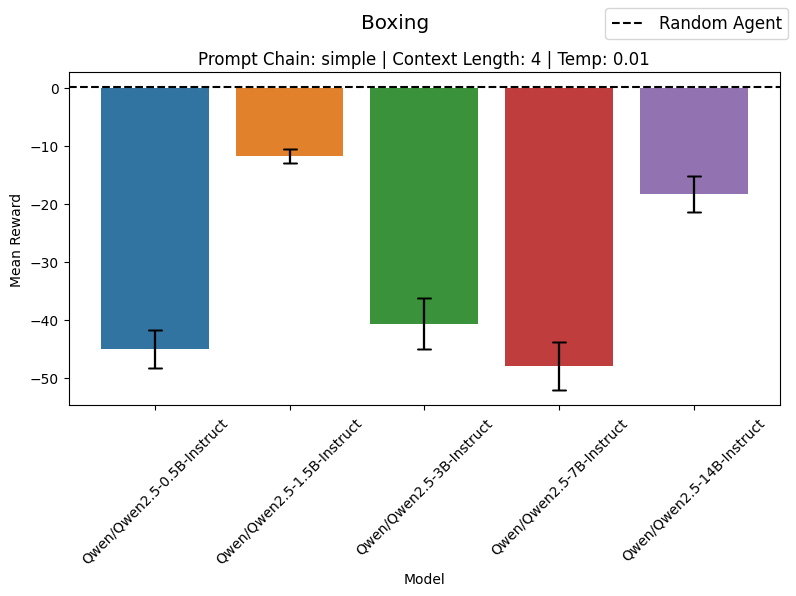

/tmp/ipykernel_2595632/1904513981.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


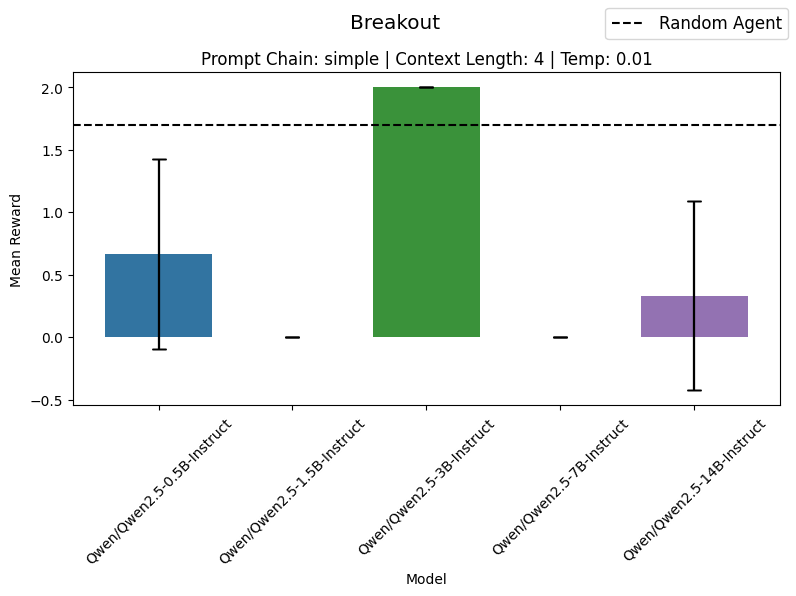

/tmp/ipykernel_2595632/1904513981.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


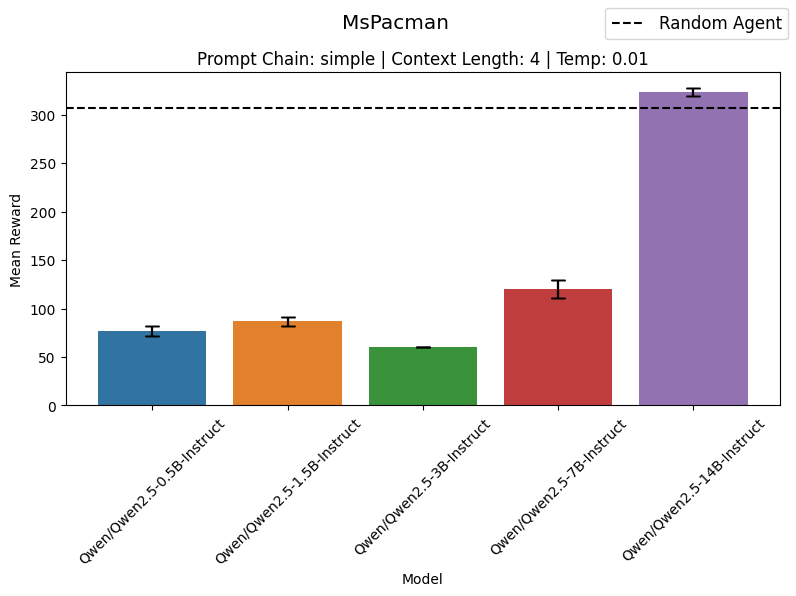

/tmp/ipykernel_2595632/1904513981.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


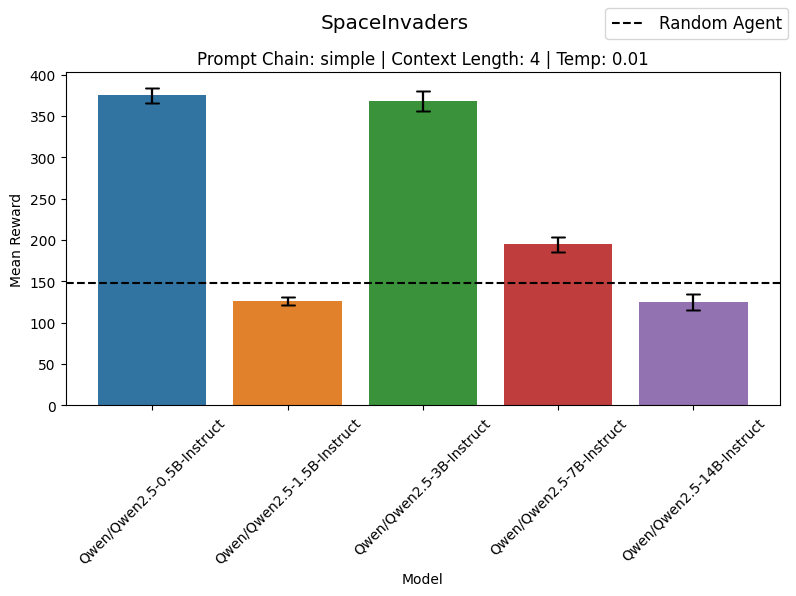

/tmp/ipykernel_2595632/1904513981.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


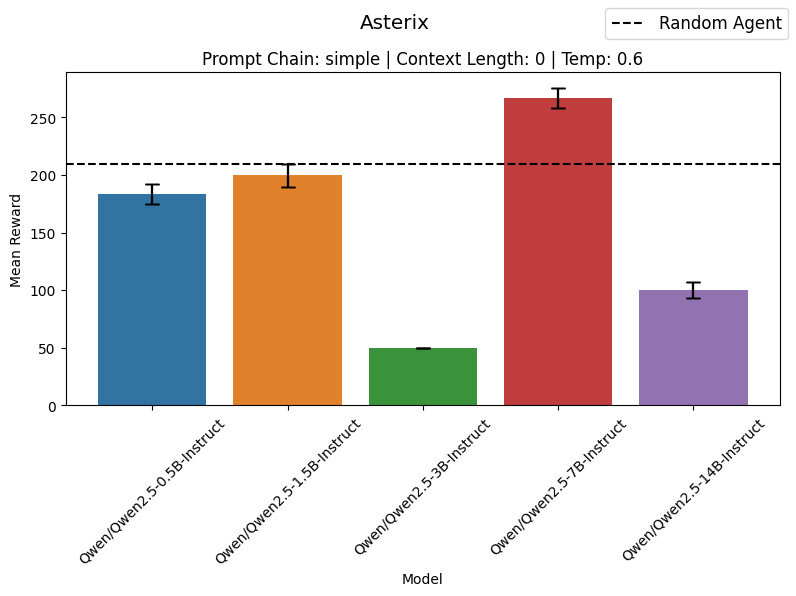

/tmp/ipykernel_2595632/1904513981.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


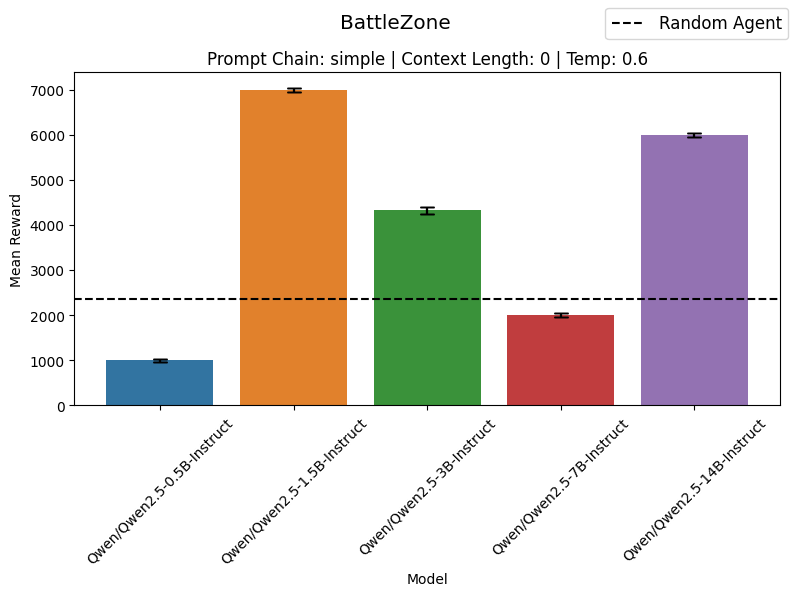

/tmp/ipykernel_2595632/1904513981.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


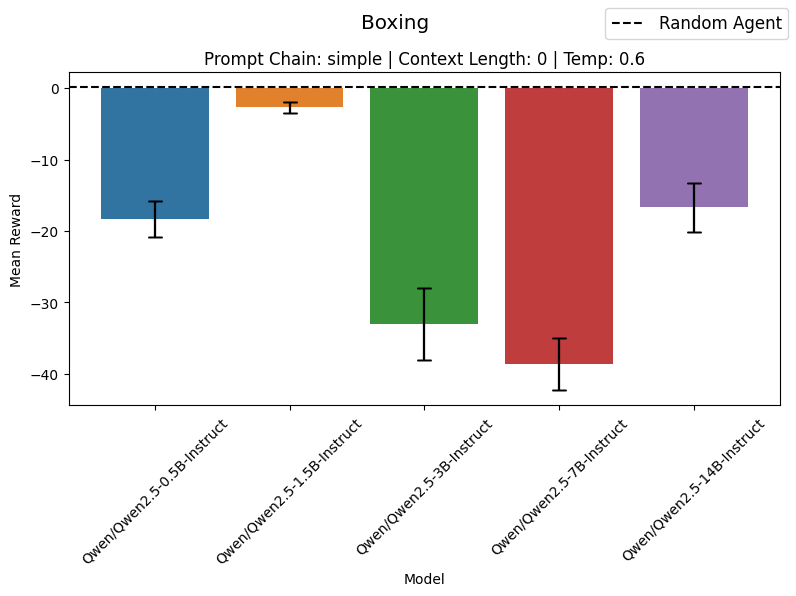

/tmp/ipykernel_2595632/1904513981.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


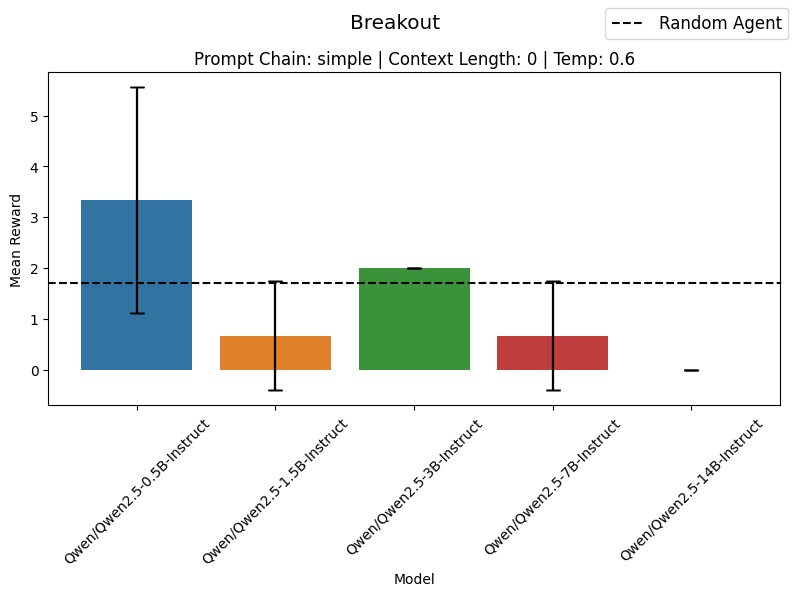

/tmp/ipykernel_2595632/1904513981.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


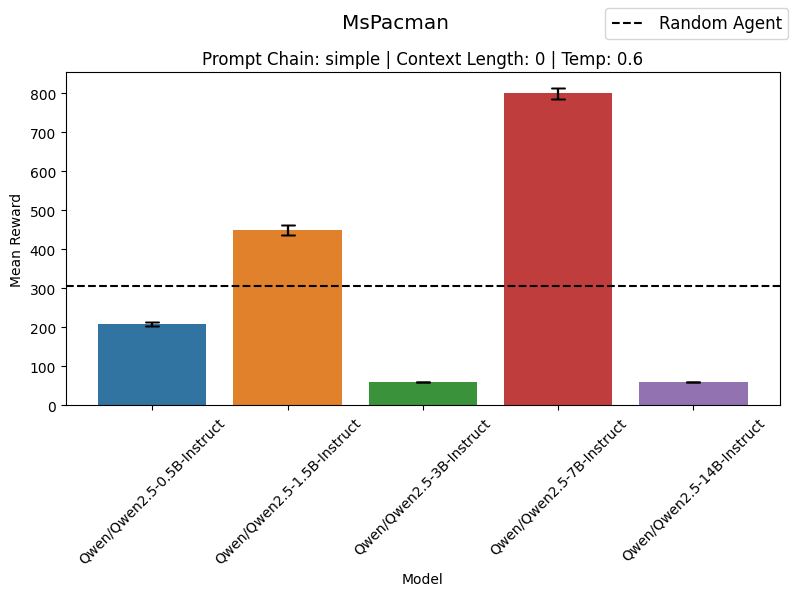

/tmp/ipykernel_2595632/1904513981.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


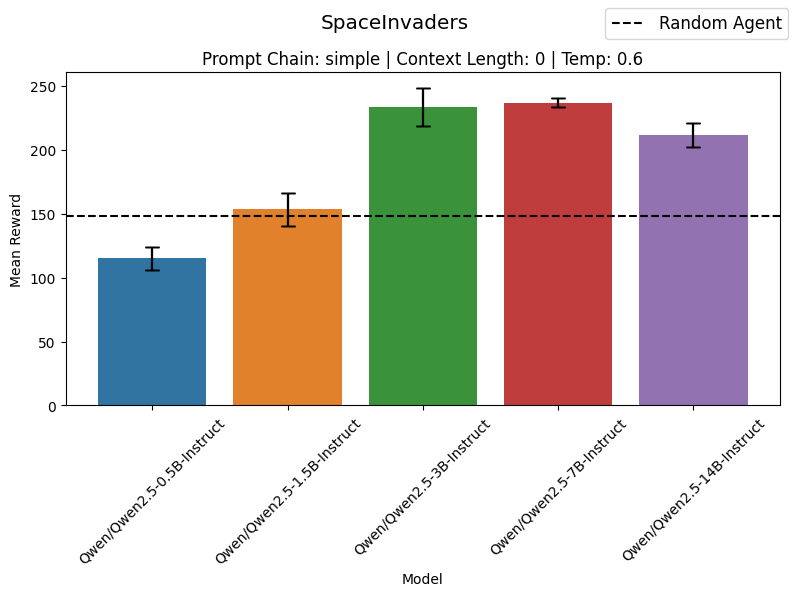

/tmp/ipykernel_2595632/1904513981.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


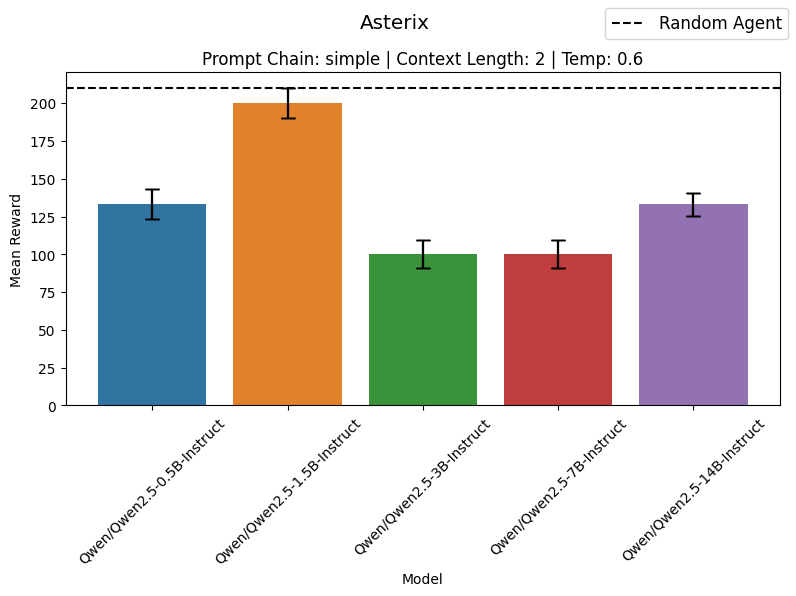

/tmp/ipykernel_2595632/1904513981.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


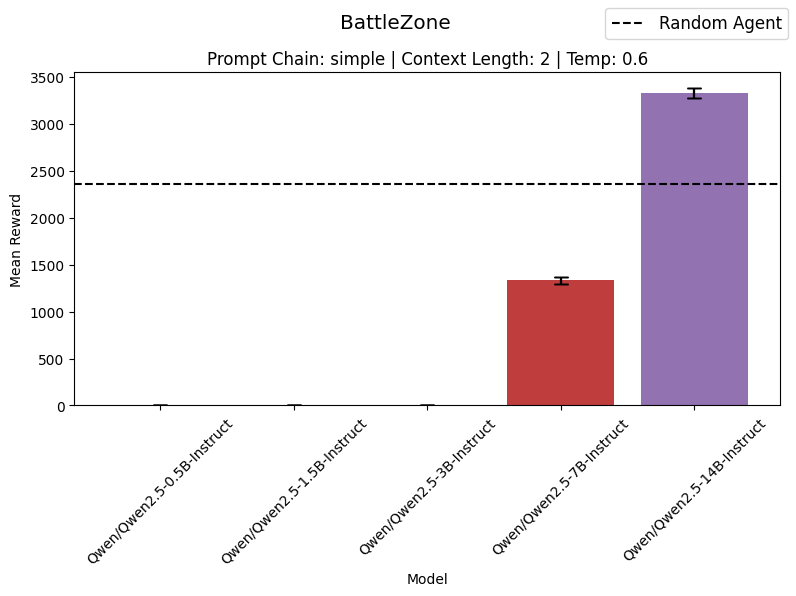

/tmp/ipykernel_2595632/1904513981.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


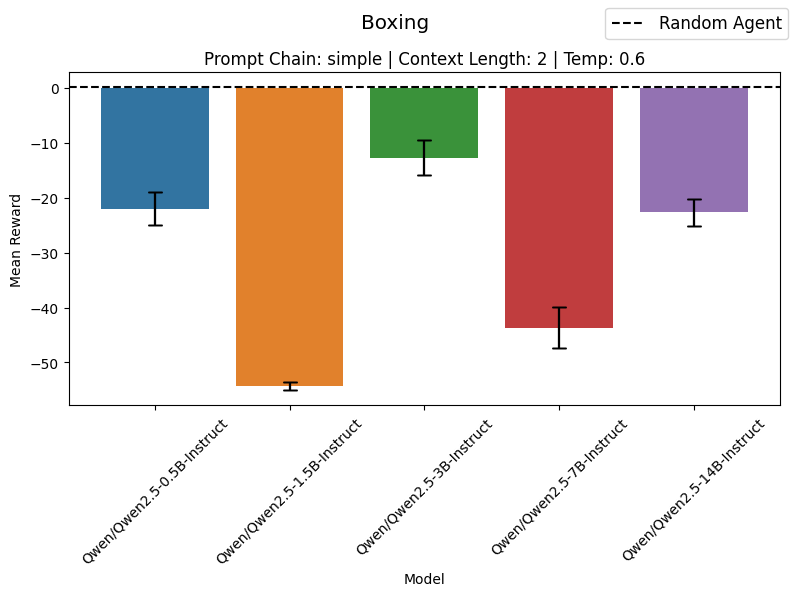

/tmp/ipykernel_2595632/1904513981.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


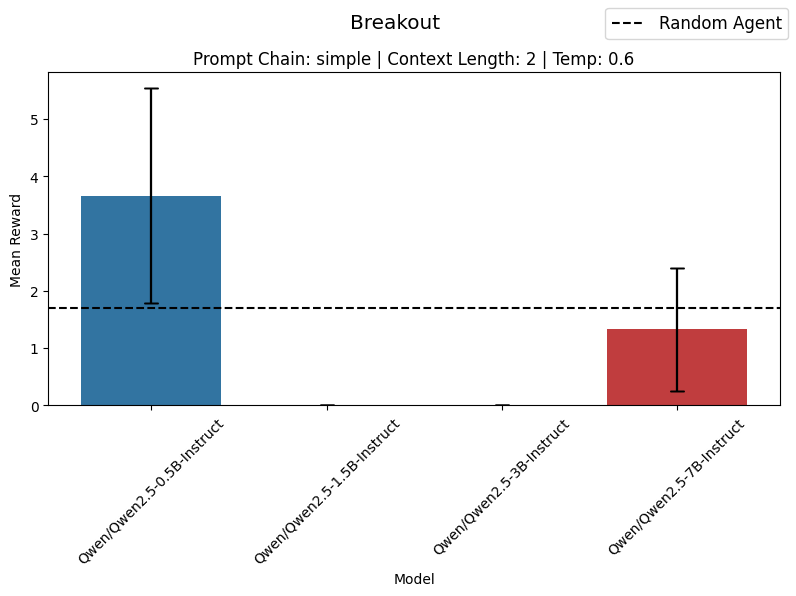

/tmp/ipykernel_2595632/1904513981.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


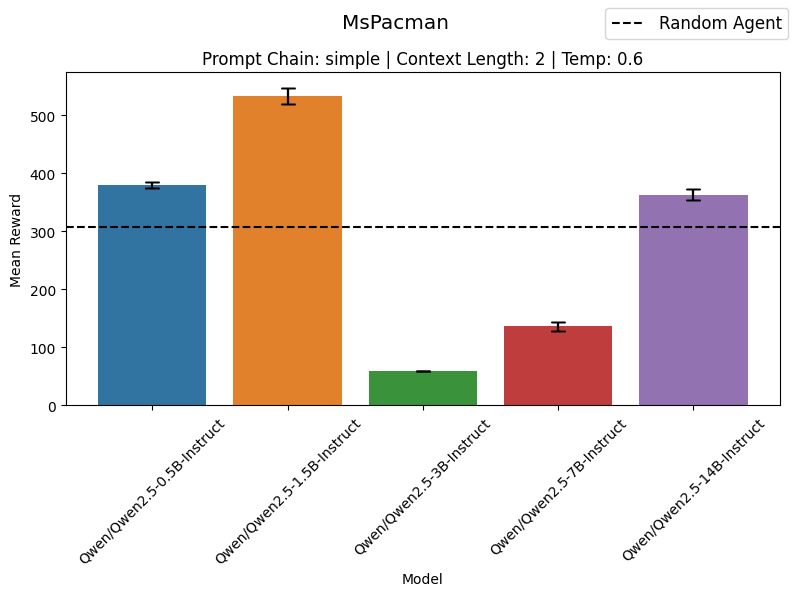

/tmp/ipykernel_2595632/1904513981.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


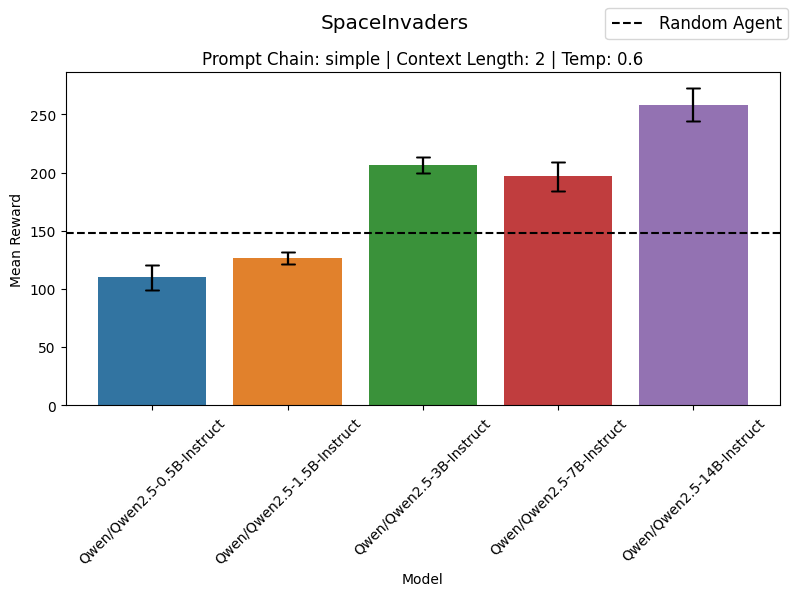

/tmp/ipykernel_2595632/1904513981.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


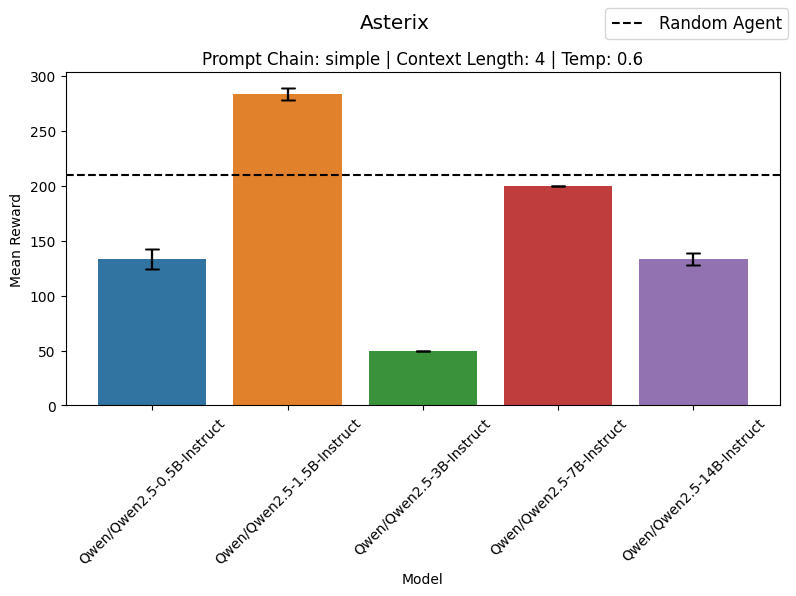

/tmp/ipykernel_2595632/1904513981.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


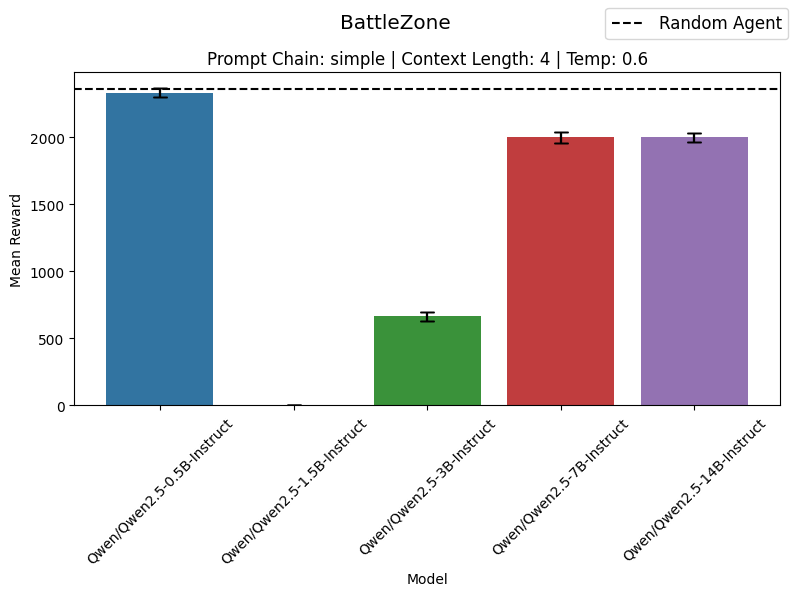

/tmp/ipykernel_2595632/1904513981.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


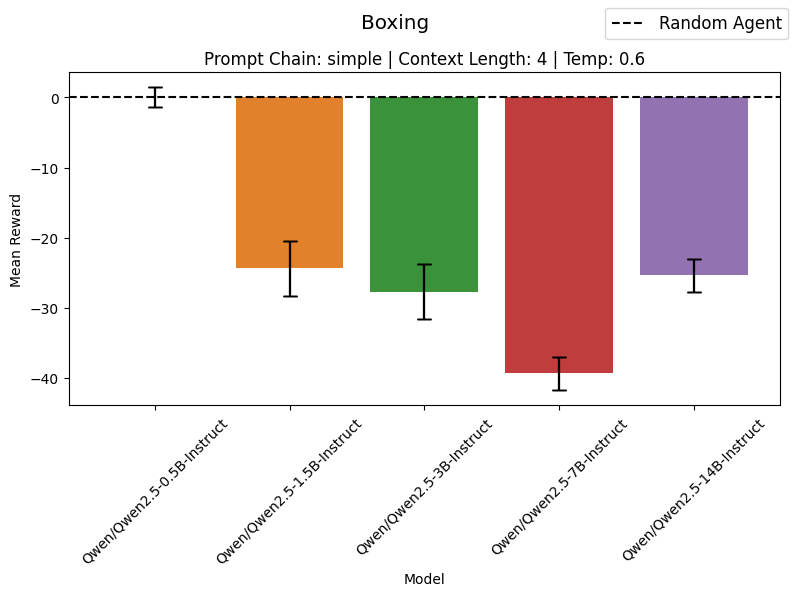

/tmp/ipykernel_2595632/1904513981.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


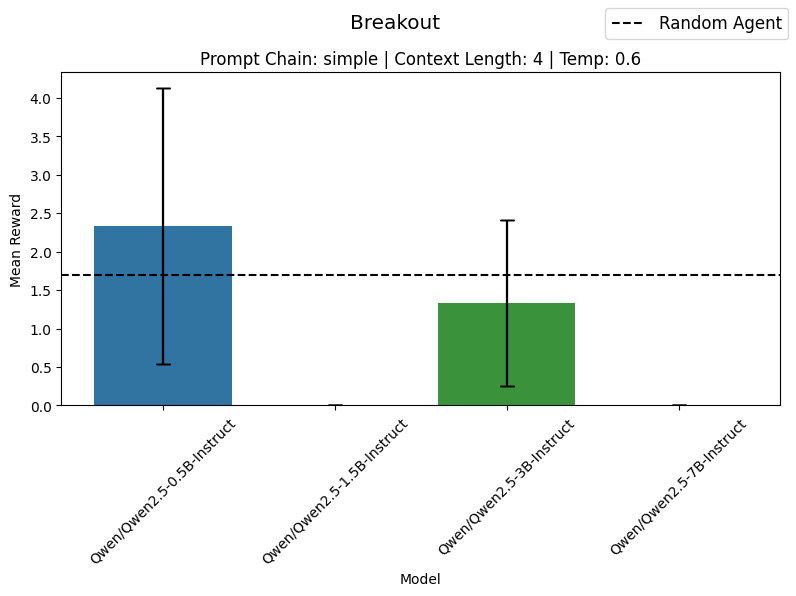

/tmp/ipykernel_2595632/1904513981.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


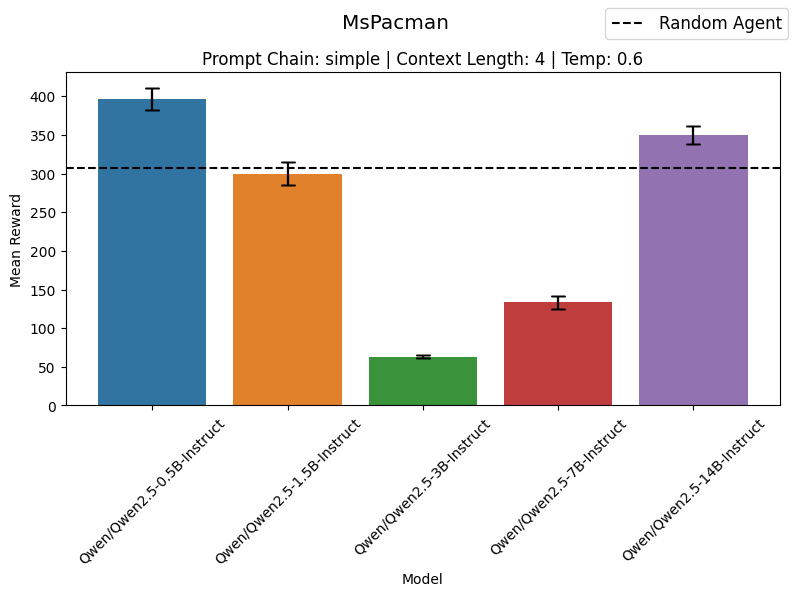

/tmp/ipykernel_2595632/1904513981.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


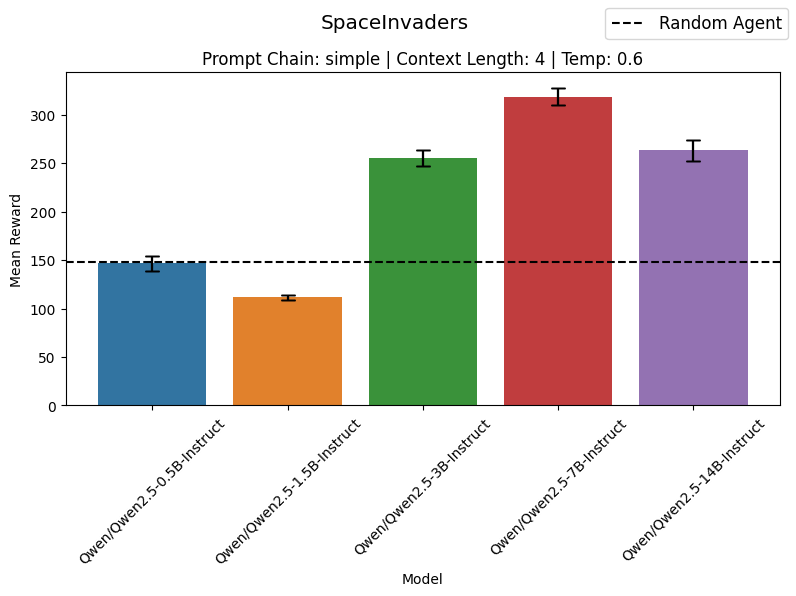

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Define a color palette based on unique model names
unique_models = df['model_name'].unique()
palette = dict(zip(unique_models, sns.color_palette("tab10", len(unique_models))))

# Get unique values
unique_prompt_chains = df['prompt_chain'].unique()
unique_context_lengths = df['context_length'].unique()
unique_temperatures = df['temperature'].unique()

# Sort environments by name
df['env_id'] = pd.Categorical(df['env_id'], categories=sorted(df['env_id'].unique()), ordered=True)

for temp in unique_temperatures:
    df_temp = df[df['temperature'] == temp]
    
    for context_len in unique_context_lengths:
        df_context = df_temp[df_temp['context_length'] == context_len]
        
        for env in df['env_id'].cat.categories:
            df_env = df_context[df_context['env_id'] == env]
            
            if df_env.empty:
                continue
            
            fig, axs = plt.subplots(1, len(unique_prompt_chains), figsize=(8, 6), sharey=True)
            
            if not isinstance(axs, np.ndarray):
                axs = [axs]
            
            for i, prompt_chain in enumerate(unique_prompt_chains):
                df_ = df_env[df_env['prompt_chain'] == prompt_chain]
                
                ax = axs[i]
                sns.barplot(
                    x='model_name', y='mean_reward', data=df_, hue='model_name',
                    ax=ax, palette=palette, ci=None
                )
                
                # Plot standard deviation error bars
                for index, row in df_.iterrows():
                    ax.errorbar(
                        x=row['model_name'], y=row['mean_reward'], yerr=np.sqrt(row['std_reward']),
                        fmt='none', ecolor='black', capsize=5
                    )
                
                ax.set_title(f"Prompt Chain: {prompt_chain} | Context Length: {context_len} | Temp: {temp}")
                ax.set_ylabel('Mean Reward')
                ax.set_xlabel('Model')
                
                # Rotate x-axis labels 45 degrees
                ax.tick_params(axis='x', rotation=45)
                
                # Random agent baseline
                random_val = human_and_random_scores[(human_and_random_scores['env_id'] == env) & (human_and_random_scores['model_name'] == 'random')]['episode_reward'].values
                if random_val.size > 0:
                    ax.axhline(y=random_val[0], color='black', linestyle='dashed', label='Random Agent')
                
                try:
                    ax.legend_.remove()
                except Exception:
                    pass
            
            # Create a single shared legend
            handles, labels = axs[0].get_legend_handles_labels()
            fig.legend(handles, labels, ncol=len(unique_models) + 2, fontsize='large')
            
            # Add title as the env
            fig.suptitle(f"{env}", fontsize='x-large')
            
            plt.tight_layout()
            plt.show()
